In [3]:
import gymnasium as gym
from gym.wrappers import RecordVideo
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import wandb
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
# https://speech.ee.ntu.edu.tw/~hylee/ml/ml2021-course-data/hw/HW12/HW12_EN.pdf
# https://github.com/john-hu/rl
# https://medium.com/no-sliver-bullet/%E5%BC%B7%E5%8C%96%E5%AD%B8%E7%BF%92-reinforcement-learning-lunar-lander-v2-1291d48b71c3


In [5]:
def fix(env, seed):
    # -deprecated- env.seed(seed)
    env.reset(seed=seed)
    env.action_space.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed = seed
    # -deprecated- torch.set_deterministic(True)
    torch.use_deterministic_algorithms = True
    torch.are_deterministic_algorithms_enabled = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


seed = 543
env = gym.make('LunarLander-v2', 
               render_mode='rgb_array')
fix(env, seed=seed)

-2.1055, total_reward:-24.7789, terminated:False


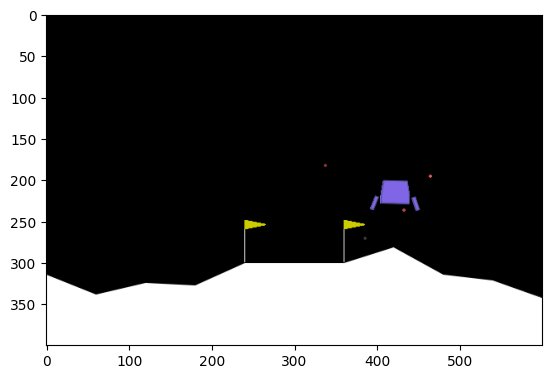

In [7]:
env = gym.make('LunarLander-v2', render_mode='rgb_array')
env.reset()
img = plt.imshow(env.render()) # only call this once
total_reward = 0
for _ in range(100):
    img.set_data(env.render()) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    print(f'\r{reward:.4f}, total_reward:{total_reward:.4f}, terminated:{terminated}')

In [8]:
# env.observation_space
# env.action_space
# initial_state, initial_info = env.reset(seed=seed)
# random_action = env.action_space.sample()
# observation, reward, terminated, truncated, info = env.step(random_action)

In [9]:
# import os
# import gymnasium as gym
# env = gym.make("LunarLander-v2", render_mode="rgb_array")
# trigger = lambda t: t % 10 == 0
# env = RecordVideo(env, video_folder="./video/video1", episode_trigger=trigger, disable_logger=True)
# for i in range(50):
#     termination, truncation = False, False
#     _ = env.reset(seed=123)
#     while not (termination or truncation):
#         obs, rew, termination, truncation, info = env.step(env.action_space.sample())

# env.close()
# len(os.listdir("./video/video1"))

# Random Agent

In [6]:
def demo_run(env, agent, seed=seed, num_episode=1, record_video=False, video_folder = './video/tmp', greedy=False):
    agent.network.eval()
    
    if not record_video:
        img = plt.imshow(env.render())
    
    for episode in range(num_episode):
        if not record_video:
            env_ = env
        else:
            trigger = lambda t: t%10 == 0
            action_mode = 'greedy' if greedy else 'sample'
            env_ = RecordVideo(env, video_folder=video_folder+f'-{action_mode}-{episode}', episode_trigger=trigger)
            
        state, info = env_.reset(seed=seed)
        terminated, truncated = False, False
        while not (terminated or truncated):
            action, log_prob = agent.sample(state, greedy)
            next_state, reward, terminated, truncated, info = env_.step(action)
            state = next_state

            if not record_video:
                img.set_data(env.render())
                display.display(plt.gcf())
                display.clear_output(wait=True)

In [12]:
# from gym.wrappers import RecordVideo
# env = gym.make('LunarLander-v2', 
#                render_mode='rgb_array')
# env.reset(seed=seed)
# #img = plt.imshow(env.render())
# trigger = lambda t: t % 100 == 0
# env = RecordVideo(env, video_folder="./video/video3", episode_trigger=trigger)

# terminated, truncated = False, False
# while not (terminated or truncated):
#     action = env.action_space.sample()
#     # observation, reward, done, _ 
#     observation, reward, terminated, truncated, info = env.step(action)

#     #img.set_data(env.render())
#     #display.display(plt.gcf())
#     #display.clear_output(wait=True)
# env.close()

# Policy Gradient

In [7]:
class PolicyGradientNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16,16)
        self.fc3 = nn.Linear(16, 4)

    # def forward(self, state):
    #     hid = torch.tanh(self.fc1(state))
    #     hid = torch.tanh(self.fc2(hid))
    #     return F.softmax(self.fc3(hid), dim=-1)

    def forward(self, state):
        hid = torch.relu(self.fc1(state))
        hid = torch.relu(self.fc2(hid))
        return F.softmax(self.fc3(hid), dim=-1)

Then, we need to build a simple agent. The agent will acts according to the output of the policy network above. There are a few things can be done by agent:

* `learn()`：update the policy network from log probabilities and rewards.
* `sample()`：After receiving observation from the environment, utilize policy network to tell which action to take. The return values of this function includes action and log probabilities.

In [8]:
class PolicyGradientAgent():
    def __init__(self, network, lr=1e-3, epochs=500):
        self.lr = lr
        self.epochs = epochs
        self.network = network
        self.optimizer = optim.SGD(self.network.parameters(), lr=1e-3)
        self.lr_scheduler = CosineAnnealingLR(self.optimizer, self.epochs, eta_min=1e-6)

    def forward(self, state):
        return self.network(state)

    def learn(self, log_probs, rewards):
        loss = (-log_probs * rewards).sum() # You don't need to revise this to pass simple baseline (but you can)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.lr_scheduler.step()
        
    def sample(self, state, greedy=False):
        action_prob = self.network(torch.FloatTensor(np.array(state)))
        action_dist = Categorical(action_prob)
        if not greedy:
            action = action_dist.sample()
        else:
            action = action_prob.argmax()
        log_prob = action_dist.log_prob(action)
        return action.item(), log_prob
 

In [ ]:
# # build a network and agent to start training
# network = PolicyGradientNetwork()
# agent = PolicyGradientAgent(network)

# Training Agent

In [ ]:
# import wandb
# import random

# # start a new wandb run to track this script
# wandb.init(
#     # set the wandb project where this run will be logged
#     project="lunalander",
    
#     # track hyperparameters and run metadata
#     config={
#     "Agent": "PolicyGradientAgent",
#     "reward": "normalized(step_reward)*step_log_prob",
#     "learning_rate": 1e-3,
#     "epochs": 500,
#     }
# )

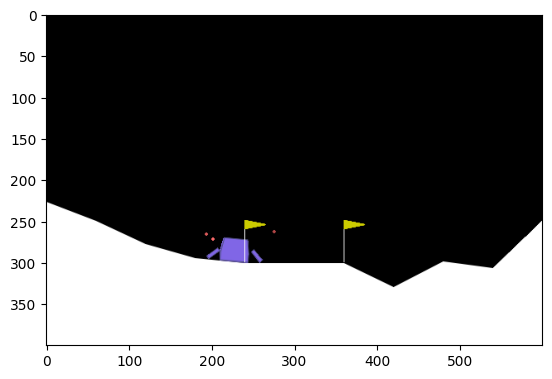

In [27]:
network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)


config = {"reward":"MC"}

agent.network.train()  # Switch network into training mode 
EPISODE_PER_BATCH = 5  # update the  agent every 5 episode
NUM_BATCH = 10        # totally update the agent for 400 time
gamma = 0.9

avg_total_rewards, avg_final_rewards = [], []


NUM_BATCH=1
EPISODE_PER_BATCH = 1
prg_bar = tqdm(range(NUM_BATCH))

    
for batch in range(NUM_BATCH):#prg_bar:
    log_probs, rewards = [], []
    total_rewards, final_rewards = [], []
    total_steps = []
    
    # collect trajectory
    for episode in range(EPISODE_PER_BATCH):
        
        state, info = env.reset()
        img = plt.imshow(env.render())
        total_reward, total_step = 0, 0
        terminated, truncated = False, False
        while not(terminated or truncated):
        # while not (terminated or truncated):
            print(f'\r{reward:.4f}, total_reward:{total_reward:.4f}, terminated:{terminated}')
            action, log_prob = agent.sample(state) # at, log(at|st)
            next_state, reward, terminated, truncated, info = env.step(action)

            # render
            img.set_data(env.render()) # just update the data
            display.display(plt.gcf())
            display.clear_output(wait=True)     
            # render       

            log_probs.append(log_prob) # [log(a1|s1), log(a2|s2), ...., log(at|st)]
            state = next_state
            total_reward += reward
            match config["reward"]:
                case "normalized_step_reward":
                    rewards.append(reward) # change here
                case "MC":
                    rewards.append(reward*(gamma**total_step))
    
            total_step += 1

            # ! IMPORTANT !
            # Current reward implementation: immediate reward,  given action_list : a1, a2, a3 ......
            #                                                         rewards :     r1, r2 ,r3 ......
            # medium：change "rewards" to accumulative decaying reward, given action_list : a1,                           a2,                           a3, ......
            #                                                           rewards :           r1+0.99*r2+0.99^2*r3+......, r2+0.99*r3+0.99^2*r4+...... ,  r3+0.99*r4+0.99^2*r5+ ......
            # boss : implement Actor-Critic

            # if terminated or truncated:
            #    final_rewards.append(reward)
            #    total_rewards.append(total_reward)
            #    break

        else:
            final_rewards.append(reward)
            total_rewards.append(total_reward)
            total_steps.append(total_step)
            state, info = env.reset()
            #img.set_data(env.render()) # just update the data
            #display.display(plt.gcf())
            #display.clear_output(wait=True)     
        
    
    # update agent
    mean_rewards = np.mean(rewards)
    std_rewards = np.std(rewards)

    match config["reward"]:
        case "normalized_step_reward":
            rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # normalize the reward 
        case "MC":
            rewards_ = []
            start = [sum(total_steps[:i]) for i in range(len(total_steps))]
            end =  [sum(total_steps[:i]) for i in range(1, len(total_steps)+1)]

            for s, e in zip(start, end):
                rewards_ = rewards_ + [ sum(rewards[s:e][i:])/(gamma**i) for i in range(len(rewards[s:e])) ]
            
            #rewards = rewards_
            #rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)
    

    #print(f"rewards looks like ", np.shape(rewards))  
    #print(f"log_probs looks like ", np.shape(log_probs))     
    # record training process
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    # update agent
    # rewards = np.concatenate(rewards, axis=0)
    mean_rewards = np.mean(rewards)
    std_rewards = np.std(rewards)
    # rewards = (np.array(rewards) - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # normalize the reward 
    #rewards = np.array(np.sum(rewards))
    #rewards = np.array([sum(rewards[i:])/(gamma**i) for i in range(len(rewards))])
    agent.learn(torch.stack(log_probs), torch.from_numpy(np.array(rewards_)))
    # print("logs prob looks like ", torch.stack(log_probs).size())
    # print("torch.from_numpy(rewards) looks like ", torch.from_numpy( np.array(rewards_) ).size())
    
    # wandb.log({"mean rewards":mean_rewards, 
    #            "std reward":std_rewards, 
    #            "avg_total_reward": avg_total_reward, 
    #            "avg_final_reward": avg_final_reward, 
    #            "avg_episode_steps":len(rewards)/EPISODE_PER_BATCH}
    # )

In [21]:
EPISODE_PER_BATCH = 5  # update the  agent every 5 episode
NUM_BATCH = 500        # totally update the agent for 400 time

def agent_run(
    env, 
    agent, 
    config, 
    episode_per_batch=EPISODE_PER_BATCH, 
    num_batch=NUM_BATCH, 
    gamma=0.99,
    step_punish = -0.15,
    wandb_log = True,
    verbose = False
):

    if wandb_log:
        wandb.init(
            # set the wandb project where this run will be logged
            project = config['project'], 
            # track hyperparameters and run metadata
            config = config
        )

    match config['phase']:
        case 'train':
            agent.network.train()  # Switch network into training mode 
        case 'eval':
            agent.network.eval()  # Switch network into eval mode 
    
    num_batch, episode_per_batch = config['num_batch'], config['episode_per_batch']
    avg_total_rewards, avg_final_rewards = [], []

    prg_bar = tqdm(range(num_batch))
    for batch in prg_bar:

        log_probs, rewards = [], []
        total_rewards, final_rewards = [], []
        total_steps = []
        # collect trajectory
        for episode in range(episode_per_batch):
            
            state, info = env.reset()
            total_reward, total_step = 0, 0
            terminated, truncated = False, False
            
            while not(terminated or truncated):
            # while not (terminated or truncated):
                action, log_prob = agent.sample(state) # at, log(at|st)
                next_state, reward, terminated, truncated, info = env.step(action)
                reward += step_punish
                # if reward == -100:
                #     reward = -10
                

                log_probs.append(log_prob) # [log(a1|s1), log(a2|s2), ...., log(at|st)]
                state = next_state
                total_reward += reward
                match config["reward"]:
                    case "normalized_step_reward":
                        rewards.append(reward) # change here
                    case "MC":
                        rewards.append(reward*(gamma**total_step))
                
                total_step += 1
                # ! IMPORTANT !
                # Current reward implementation: immediate reward,  given action_list : a1, a2, a3 ......
                #                                                         rewards :     r1, r2 ,r3 ......
                # medium：change "rewards" to accumulative decaying reward, given action_list : a1,                           a2,                           a3, ......
                #                                                           rewards :           r1+0.99*r2+0.99^2*r3+......, r2+0.99*r3+0.99^2*r4+...... ,  r3+0.99*r4+0.99^2*r5+ ......
                # boss : implement Actor-Critic

                # if terminated or truncated:
                #    final_rewards.append(reward)
                #    total_rewards.append(total_reward)
                #    break

            else:
                final_rewards.append(reward)
                total_rewards.append(total_reward)
                total_steps.append(total_step)
                
            

        # record training process
        avg_total_reward = sum(total_rewards) / len(total_rewards)
        avg_final_reward = sum(final_rewards) / len(final_rewards)
        avg_total_rewards.append(avg_total_reward)
        avg_final_rewards.append(avg_final_reward)
        avg_episode_steps = sum(total_steps)/len(total_steps)
        prg_bar.set_description(f"\r Total reward: {avg_total_reward: 4.1f}, Final reward: {avg_final_reward: 4.1f}")

        # update agent
        mean_rewards = np.mean(rewards)
        std_rewards = np.std(rewards)

        match config["reward"]:
            case "normalized_step_reward":
                rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # normalize the reward 
            case "MC":
                rewards_ = []
                start = [sum(total_steps[:i]) for i in range(len(total_steps))]
                end =  [sum(total_steps[:i]) for i in range(1, len(total_steps)+1)]

                for s, e in zip(start, end):
                    rewards_ = rewards_ + [ sum(rewards[s:e][i:])/(gamma**i) for i in range(len(rewards[s:e])) ]
                
                rewards = rewards_
                rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)
        
                #rewards = np.array([sum(rewards[i:])/(gamma**i) for i in range(len(rewards))])
                #rewards = np.array(np.sum(rewards))

        agent.learn(torch.stack(log_probs), torch.from_numpy(rewards))
        if verbose:
            print("logs prob looks like ", torch.stack(log_probs).size())
            print("torch.from_numpy(rewards) looks like ", torch.from_numpy(rewards).size())

        if wandb_log:
            wandb.log({"mean rewards":mean_rewards, 
                    "std reward":std_rewards, 
                    "avg_total_reward": avg_total_reward, 
                    "avg_final_reward": avg_final_reward, 
                    "avg_episode_steps":avg_episode_steps}
            )

    match config['phase']:
        case 'train':
            torch.save(agent.network.state_dict(), config['output_dir'])


In [48]:
EPISODE_PER_BATCH = 5  # update the  agent every 5 episode
NUM_BATCH = 1        # totally update the agent for 400 time

# def agent_run(
#     env, 
#     agent, 
#     config, 
#     episode_per_batch=EPISODE_PER_BATCH, 
#     num_batch=NUM_BATCH, 
#     gamma=0.99,
#     wandb_log = True,
#     verbose = False
# ):
env = gym.make('LunarLander-v2', render_mode='rgb_array')
env.reset(seed=seed)

network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)

config={
    "agent": "PolicyGradientAgent",
    "phase": "train",
    "project": "lunalander",
    "reward": "MC",
    "learning_rate": 1e-3,
    "num_batch": 1,
    "episode_per_batch": 5,
    "output_dir": "./models/policy_gradient_normalized_step_reward"
}
episode_per_batch=EPISODE_PER_BATCH 
num_batch=NUM_BATCH
gamma=0.99
wandb_log = True
verbose = False

if True:

    if wandb_log:
        wandb.init(
            # set the wandb project where this run will be logged
            project = config['project'], 
            # track hyperparameters and run metadata
            config = config
        )

    match config['phase']:
        case 'train':
            agent.network.train()  # Switch network into training mode 
        case 'eval':
            agent.network.eval()  # Switch network into eval mode 
    
    num_batch, episode_per_batch = config['num_batch'], config['episode_per_batch']
    avg_total_rewards, avg_final_rewards = [], []

    prg_bar = tqdm(range(num_batch))
    for batch in prg_bar:

        log_probs, rewards = [], []
        total_rewards, final_rewards = [], []
        total_steps = []
        original_rewards = []
        # collect trajectory
        for episode in range(episode_per_batch):
            
            state, info = env.reset()
            total_reward, total_step = 0, 0
            terminated, truncated = False, False
            
            while not(terminated or truncated):
            # while not (terminated or truncated):
                action, log_prob = agent.sample(state) # at, log(at|st)
                next_state, reward, terminated, truncated, info = env.step(action)
                

                log_probs.append(log_prob) # [log(a1|s1), log(a2|s2), ...., log(at|st)]
                state = next_state
                total_reward += reward
                match config["reward"]:
                    case "normalized_step_reward":
                        rewards.append(reward) # change here
                    case "MC":
                        rewards.append(reward*(gamma**total_step))
                        original_rewards.append(reward)
                
                total_step += 1
                # ! IMPORTANT !
                # Current reward implementation: immediate reward,  given action_list : a1, a2, a3 ......
                #                                                         rewards :     r1, r2 ,r3 ......
                # medium：change "rewards" to accumulative decaying reward, given action_list : a1,                           a2,                           a3, ......
                #                                                           rewards :           r1+0.99*r2+0.99^2*r3+......, r2+0.99*r3+0.99^2*r4+...... ,  r3+0.99*r4+0.99^2*r5+ ......
                # boss : implement Actor-Critic

                # if terminated or truncated:
                #    final_rewards.append(reward)
                #    total_rewards.append(total_reward)
                #    break

            else:
                final_rewards.append(reward)
                total_rewards.append(total_reward)
                total_steps.append(total_step)
                
            

        # record training process
        avg_total_reward = sum(total_rewards) / len(total_rewards)
        avg_final_reward = sum(final_rewards) / len(final_rewards)
        avg_total_rewards.append(avg_total_reward)
        avg_final_rewards.append(avg_final_reward)
        avg_episode_steps = sum(total_steps)/len(total_steps)
        prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

        # update agent
        mean_rewards = np.mean(rewards)
        std_rewards = np.std(rewards)

        match config["reward"]:
            case "normalized_step_reward":
                rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # normalize the reward 
            case "MC":
                rewards_ = []
                start = [sum(total_steps[:i]) for i in range(len(total_steps))]
                end =  [sum(total_steps[:i]) for i in range(1, len(total_steps)+1)]

                for s, e in zip(start, end):
                    rewards_ = rewards_ + [ sum(rewards[s:e][i:])/(gamma**i) for i in range(len(rewards[s:e])) ]
                
                rewards = np.array(rewards_)
                #rewards = rewards_
                #rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)


        agent.learn(torch.stack(log_probs), torch.from_numpy(rewards))
        if verbose:
            print("logs prob looks like ", torch.stack(log_probs).size())
            print("torch.from_numpy(rewards) looks like ", torch.from_numpy(rewards).size())

        if wandb_log:
            wandb.log({"mean rewards":mean_rewards, 
                    "std reward":std_rewards, 
                    "avg_total_reward": avg_total_reward, 
                    "avg_final_reward": avg_final_reward, 
                    "avg_episode_steps":avg_episode_steps}
            )

    match config['phase']:
        case 'train':
            torch.save(agent.network.state_dict(), config['output_dir'])


avg_episode_steps,▁
avg_final_reward,▁
avg_total_reward,▁
mean rewards,▁
std reward,▁
avg_episode_steps,82.4
avg_final_reward,-100.0
avg_total_reward,-225.74438
mean rewards,-1.50772
std reward,5.7599


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# train
env = gym.make('LunarLander-v2', render_mode='rgb_array')
env.reset(seed=seed)

network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)

config={
    "agent": "PolicyGradientAgent",
    "phase": "train",
    "project": "lunalander",
    "reward": "normalized_step_reward",
    "learning_rate": 1e-3,
    "num_batch": 500,
    "episode_per_batch": 5,
    "output_dir": "./models/policy_gradient_normalized_step_reward"
}

agent_run(env, agent, config=config)


In [ ]:
network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)
agent.network.load_state_dict(torch.load(config["output_dir"]))

env = gym.make('LunarLander-v2', render_mode='rgb_array')
env.reset(seed=seed)
demo_run(env, agent, seed=seed, record_video=True, video_folder = f"./video/policy_gradient_normalized_step_reward", greedy=True)
env.reset(seed=seed)
demo_run(env, agent, seed=seed, record_video=True, video_folder = f"./video/policy_gradient_normalized_step_reward", greedy=False)

In [22]:
# train
env = gym.make('LunarLander-v2', render_mode='rgb_array')
env.reset(seed=seed)

network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)

config={
    "agent": "PolicyGradientAgent",
    "phase": "train",
    "project": "lunalander",
    "reward": "MC",
    "learning_rate": 1e-3,
    "num_batch": 500,
    "episode_per_batch": 5,
    "output_dir": "./models/policy_gradient_MC_gamma_0.7"
}

agent_run(env, agent, config=config, gamma=0.7)

network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)
agent.network.load_state_dict(torch.load(config["output_dir"]))

env = gym.make('LunarLander-v2', render_mode='rgb_array')
env.reset(seed=seed)
demo_run(env, agent, seed=seed, record_video=True, video_folder = f"./video/policy_gradient_MC_gamma_0.7_advantage_step_punish", greedy=True)
env.reset(seed=seed)
demo_run(env, agent, seed=seed, record_video=True, video_folder = f"./video/policy_gradient_MC_gamma_0.7_advantage_step_punish", greedy=False)


avg_episode_steps,▁▁▁▂▂▁▂▁▂▂▂▂▂▂▂▂▂▅▂▃▅▂▃▃▂▂▃█▅▃▆▄▅▄▆▃▆▅▃▅
avg_final_reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁█▄▁██▄▁█▁▁▄
avg_total_reward,▅▅▆▅▅▄▄▄▃▂▄▄▇▆▅▁▃▄▅▃▄▆▅▆▇▇▅▆▆▇▆▆▆█▇▆▆▆▆▇
mean rewards,▃▁▅▂▂▂▂▃▂▁▄▂▃▂▆▅▃▅▄▄▅▆▅▅█▆▅▅▆▆▅▅▆▅▆▆▆▆▆▆
std reward,▅▇▆██▆▇█▅▅▄▇▆▆▇▆▄▂▄▅▂▄▃▄▆▃▃▁▂▃▃▂▂▁▂▂▂▂▃▃
avg_episode_steps,293.2
avg_final_reward,-100.0
avg_total_reward,-88.1218
mean rewards,0.00639
std reward,0.0861


  0%|          | 0/500 [00:00<?, ?it/s]

/home/jupyter/venv/rl-exp/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.is_vector_env to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.is_vector_env` for environment variables or `env.get_wrapper_attr('is_vector_env')` that will search the reminding wrappers.
  logger.warn(


Moviepy - Building video /home/jupyter/github/openai-gym/video/policy_gradient_MC_gamma_0.7_advantage_step_punish-greedy-0/rl-video-episode-0.mp4.
Moviepy - Writing video /home/jupyter/github/openai-gym/video/policy_gradient_MC_gamma_0.7_advantage_step_punish-greedy-0/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/jupyter/github/openai-gym/video/policy_gradient_MC_gamma_0.7_advantage_step_punish-greedy-0/rl-video-episode-0.mp4
Moviepy - Building video /home/jupyter/github/openai-gym/video/policy_gradient_MC_gamma_0.7_advantage_step_punish-sample-0/rl-video-episode-0.mp4.
Moviepy - Writing video /home/jupyter/github/openai-gym/video/policy_gradient_MC_gamma_0.7_advantage_step_punish-sample-0/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/jupyter/github/openai-gym/video/policy_gradient_MC_gamma_0.7_advantage_step_punish-sample-0/rl-video-episode-0.mp4


In [ ]:
# train
env = gym.make('LunarLander-v2', render_mode='rgb_array')
env.reset(seed=seed)

network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)

config={
    "agent": "PolicyGradientAgent",
    "phase": "train",
    "project": "lunalander",
    "reward": "MC",
    "learning_rate": 1e-3,
    "num_batch": 500,
    "episode_per_batch": 1,
    "output_dir": "./models/policy_gradient_MC_gamma_0.90"
}

agent_run(env, agent, config=config, gamma=0.90)


network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)
agent.network.load_state_dict(torch.load(config["output_dir"]))

env = gym.make('LunarLander-v2', render_mode='rgb_array')
env.reset(seed=seed)
demo_run(env, agent, seed=seed, record_video=True, video_folder = f"./video/policy_gradient_MC_gamma_0.90", greedy=True)
env.reset(seed=seed)
demo_run(env, agent, seed=seed, record_video=True, video_folder = f"./video/policy_gradient_MC_gamma_0.90", greedy=False)


In [ ]:
# train
env = gym.make('LunarLander-v2', render_mode='rgb_array')
env.reset(seed=seed)

network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)

config={
    "agent": "PolicyGradientAgent",
    "phase": "train",
    "project": "lunalander",
    "reward": "MC",
    "learning_rate": 1e-3,
    "num_batch": 500,
    "episode_per_batch": 5,
    "output_dir": "./models/policy_gradient_MC_gamma_0.90_episode_per_batch_5_normalized"
}

agent_run(env, agent, config=config, gamma=0.90)


network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)
agent.network.load_state_dict(torch.load(config["output_dir"]))

env = gym.make('LunarLander-v2', render_mode='rgb_array')
env.reset(seed=seed)
demo_run(env, agent, seed=seed, record_video=True, video_folder = f"./video/policy_gradient_MC_gamma_090_episode_per_batch_5_normalized", greedy=True)
env.reset(seed=seed)
demo_run(env, agent, seed=seed, record_video=True, video_folder = f"./video/policy_gradient_MC_gamma_090_episode_per_batch_5_normalized", greedy=False)


In [ ]:
# train
env = gym.make('LunarLander-v2', render_mode='rgb_array')
env.reset(seed=seed)

network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)

config={
    "agent": "PolicyGradientAgent",
    "phase": "train",
    "project": "lunalander",
    "reward": "MC",
    "learning_rate": 1e-3,
    "num_batch": 10000,
    "episode_per_batch": 1,
    "output_dir": "./models/policy_gradient_MC_gamma_0.90"
}

agent_run(env, agent, config=config, gamma=0.8)


network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)
agent.network.load_state_dict(torch.load(config["output_dir"]))

env = gym.make('LunarLander-v2', render_mode='rgb_array')
env.reset(seed=seed)
demo_run(env, agent, seed=seed, record_video=True, video_folder = f"./video/policy_gradient_MC_gamma_0.90_batch_10000", greedy=True)
env.reset(seed=seed)
demo_run(env, agent, seed=seed, record_video=True, video_folder = f"./video/policy_gradient_MC_gamma_0.90_batch_10000", greedy=False)
